In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
r = open('../annotations/list.txt')
txt = r.read().split('\n')
r.close()
txt = txt[6:-1]

name = []
species = []
for line in txt:
    line = line.split(' ')
    name.append(line[0])
    species.append(int(line[2]))

In [3]:
img_path = '../images/'
mask_path = '../annotations/trimaps/'

In [4]:
def load_img(path, name):
    X = []
    count = 0
    while count < len(name):
        temp_x = []
        temp_name = []
        if count+200 < len(name):
            temp_name = name[count:count+200]
        else:
            temp_name = name[count:]
        
        cnt = 0
        for img in temp_name:
            x = cv2.imread(path+img+'.jpg', cv2.IMREAD_COLOR)
            x = cv2.resize(x, (128, 128))
            x = x.astype(np.float)
            x = np.reshape(x, (1, 128, 128, 3))
            if cnt == 0:
                temp_x = x
            else:
                temp_x = np.concatenate((temp_x, x), axis=0)
            cnt += 1
        if count == 0:
            X = temp_x
        else:
            X = np.concatenate((X, temp_x), axis=0)
        
        count += 200
        print(X.shape)
    
    #X = np.concatenate((X))

    return X

In [5]:
X = load_img(img_path, name)

(200, 128, 128, 3)
(400, 128, 128, 3)
(600, 128, 128, 3)
(800, 128, 128, 3)
(1000, 128, 128, 3)
(1200, 128, 128, 3)
(1400, 128, 128, 3)
(1600, 128, 128, 3)
(1800, 128, 128, 3)
(2000, 128, 128, 3)
(2200, 128, 128, 3)
(2400, 128, 128, 3)
(2600, 128, 128, 3)
(2800, 128, 128, 3)
(3000, 128, 128, 3)
(3200, 128, 128, 3)
(3400, 128, 128, 3)
(3600, 128, 128, 3)
(3800, 128, 128, 3)
(4000, 128, 128, 3)
(4200, 128, 128, 3)
(4400, 128, 128, 3)
(4600, 128, 128, 3)
(4800, 128, 128, 3)
(5000, 128, 128, 3)
(5200, 128, 128, 3)
(5400, 128, 128, 3)
(5600, 128, 128, 3)
(5800, 128, 128, 3)
(6000, 128, 128, 3)
(6200, 128, 128, 3)
(6400, 128, 128, 3)
(6600, 128, 128, 3)
(6800, 128, 128, 3)
(7000, 128, 128, 3)
(7200, 128, 128, 3)
(7349, 128, 128, 3)


In [8]:
def load_mask(path, name):
    Y = []
    count = 0
    while count < len(name):
        temp_y = []
        temp_name = []
        temp_species = []
        if count+200 < len(name):
            temp_name = name[count:count+200]
            temp_species = species[count:count+200]
        else:
            temp_name = name[count:]
            temp_species = species[count:count+200]
        
        cnt = 0
        for k in range(len(temp_name)):
            y = cv2.imread(path+temp_name[k]+'.png', cv2.IMREAD_GRAYSCALE)
            y = cv2.resize(y, (128, 128))
            
            if temp_species[k] == 1:
                for i in range(y.shape[0]):
                    for j in range(y.shape[1]):
                        if y[i][j] == 3:
                            y[i][j] = 1
            else:
                for i in range(y.shape[0]):
                    for j in range(y.shape[1]):
                        if y[i][j] == 3 or y[i][j] == 1:
                            y[i][j] = 0
            
            y = y.astype(np.int)
            y = np.reshape(y, (1, 128, 128))
            if cnt == 0:
                temp_y = y
            else:
                temp_y = np.concatenate((temp_y, y), axis=0)
            cnt += 1
        if count == 0:
            Y = temp_y
        else:
            Y = np.concatenate((Y, temp_y), axis=0)
        
        count += 200
        print(Y.shape)

    return Y

In [9]:
y = load_mask(mask_path, name)

(200, 128, 128)
(400, 128, 128)
(600, 128, 128)
(800, 128, 128)
(1000, 128, 128)
(1200, 128, 128)
(1400, 128, 128)
(1600, 128, 128)
(1800, 128, 128)
(2000, 128, 128)
(2200, 128, 128)
(2400, 128, 128)
(2600, 128, 128)
(2800, 128, 128)
(3000, 128, 128)
(3200, 128, 128)
(3400, 128, 128)
(3600, 128, 128)
(3800, 128, 128)
(4000, 128, 128)
(4200, 128, 128)
(4400, 128, 128)
(4600, 128, 128)
(4800, 128, 128)
(5000, 128, 128)
(5200, 128, 128)
(5400, 128, 128)
(5600, 128, 128)
(5800, 128, 128)
(6000, 128, 128)
(6200, 128, 128)
(6400, 128, 128)
(6600, 128, 128)
(6800, 128, 128)
(7000, 128, 128)
(7200, 128, 128)
(7349, 128, 128)


In [10]:
X = X/255

In [11]:
X_train = X[:4409]
y_train = y[:4409]

X_valid = X[4409:5879]
y_valid = y[4409:5879]

X_test = X[5879:]
y_test = y[5879:]

In [18]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

In [19]:
def unet(shape, num_classes):
    inputs = Input(shape)

    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    b1 = conv_block(p4, 128, pool=False)

    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

In [20]:
shape = (128, 128, 3)
num_classes = 3
lr = 1e-4
batch_size = 8
epochs = 30

In [21]:
model = unet(shape, num_classes)
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 128, 16) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [22]:
callbacks = [
    ModelCheckpoint("model.h5", save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True)
]

In [23]:
model.fit(x=X_train, y=y_train,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/30
552/552 [==============================] - 457s 825ms/step - loss: 0.9074 - val_loss: 0.7267
Epoch 2/30
552/552 [==============================] - 457s 828ms/step - loss: 0.6890 - val_loss: 0.6110
Epoch 3/30
552/552 [==============================] - 490s 888ms/step - loss: 0.6142 - val_loss: 0.5641
Epoch 4/30
552/552 [==============================] - 469s 849ms/step - loss: 0.5501 - val_loss: 0.5723
Epoch 5/30
552/552 [==============================] - 467s 846ms/step - loss: 0.5056 - val_loss: 0.4567
Epoch 6/30
552/552 [==============================] - 448s 811ms/step - loss: 0.4675 - val_loss: 0.4385
Epoch 7/30
552/552 [==============================] - 450s 815ms/step - loss: 0.4281 - val_loss: 0.4586
Epoch 8/30
552/552 [==============================] - 485s 880ms/step - loss: 0.3970 - val_loss: 0.4864
Epoch 9/30
552/552 [==============================] - 482s 874ms/step - loss: 0.3665 - val_loss: 0.4195
Epoch 10/30
552/552 [==============================] - 479s 868m

In [131]:
model = tf.keras.models.load_model('model_.h5')

In [132]:
test_mask = model.predict(np.reshape(X_test[200], (1, 128, 128, 3)))

In [133]:
test_mask = np.argmax(test_mask, axis=3)

In [134]:
test_mask = test_mask[0]

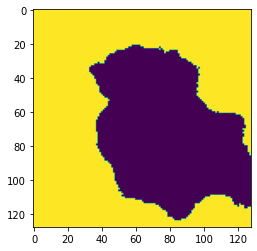

In [135]:
plt.imshow(test_mask)

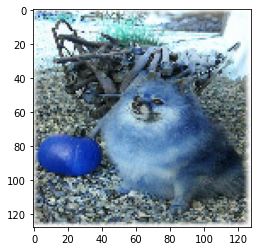

In [136]:
plt.imshow(X_test[200])

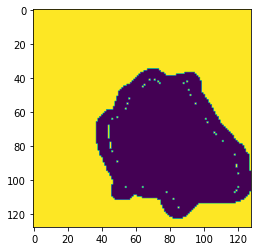

In [137]:
plt.imshow(y_test[200])